In [1]:
%matplotlib inline
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import math

input_text_file = "Fuzuli-I.txt"

with open(input_text_file, "r", encoding="utf-8") as f:
    input_text = f.read()

# Whitespace Tokenization

In [2]:
# Whitespace tokenization - letter only, stored in a dataframe
tokens = re.findall(r"\p{L}+(?:-\p{L}+)*", input_text)
df = pd.DataFrame(tokens, columns=["tokens"])
df['tokens'] = df['tokens'].str.lower()

In [3]:
# Unique tokens with counts and percentage
counts = df['tokens'].value_counts()
total = counts.sum()
unique_df = pd.DataFrame({
    'token': counts.index,
    'count': counts.values,
    'frequency (%)': (counts.values/total*100).round(2)
})

# Total number of tokens
print("Token number of tokens:", total)

# Number of unique tokens
unique_count = df['tokens'].nunique() 
print("\nNumber of unique tokens:", unique_count)

# Top 15 most frequent tokens
print("\n",unique_df.head(15).to_string(index=False))

Token number of tokens: 32107

Number of unique tokens: 11340

  token  count  frequency (%)
   kim    564           1.76
    ey    479           1.49
   bir    449           1.40
    ki    424           1.32
    ol    360           1.12
    bu    288           0.90
   ilə    286           0.89
   hər    286           0.89
füzuli    270           0.84
    nə    242           0.75
   mən    160           0.50
  məni    148           0.46
   tək    141           0.44
   var    130           0.40
  mənə    117           0.36


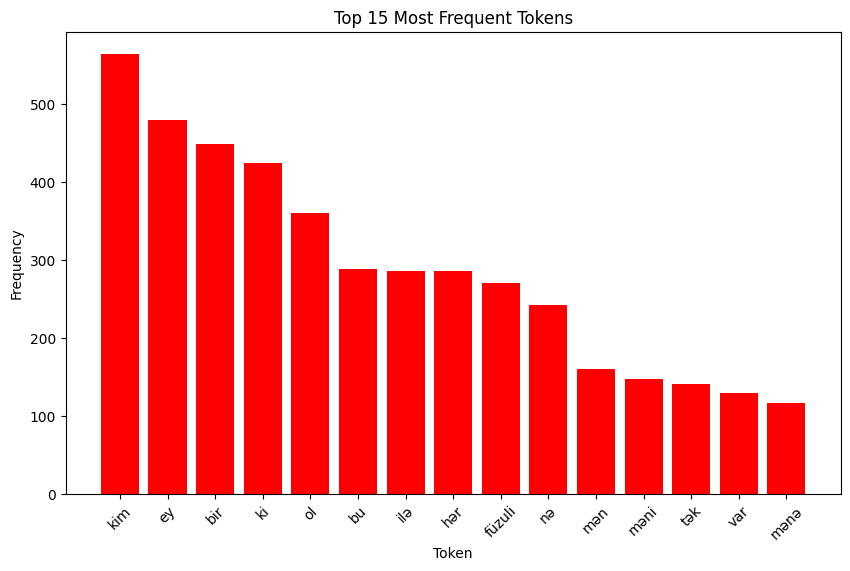

In [4]:
top15 = unique_df.head(15)

plt.figure(figsize=(10,6))
plt.bar(top15['token'], top15['count'], color="red")

plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Top 15 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.show()


# Heaps' Law

In [5]:
# Heaps Law
df_clean = df[~df['tokens'].isin(['.', '!', '?'])].copy()

def get_N_V(df):
    
    N, V = [], []
    all_tokens = df['tokens'].tolist()
    seen = set()

    for i, tok in enumerate(all_tokens, start=1):
        N.append(i)
        seen.add(tok)
        V.append(len(seen))

    return N, V

# linear regression
def lin_reg(N, V):

    x = [math.log(n) for n in N]
    y = [math.log(v) for v in V]

    x_mean = sum(x) / len(x)
    y_mean = sum(y) / len(y)

    # y = a + beta*x | Least Square Estimation
    beta = sum((xi - x_mean)*(yi - y_mean) for xi, yi in zip(x,y))/sum((xi - x_mean)**2 for xi in x)
    a = y_mean - beta * x_mean
    k = math.exp(a)

    return k, beta

N, V = get_N_V(df_clean)

k, beta = lin_reg(N, V)

print("Value of k:", k, "\nValue of beta:", beta)

Value of k: 2.551145943335604 
Value of beta: 0.81126260054735


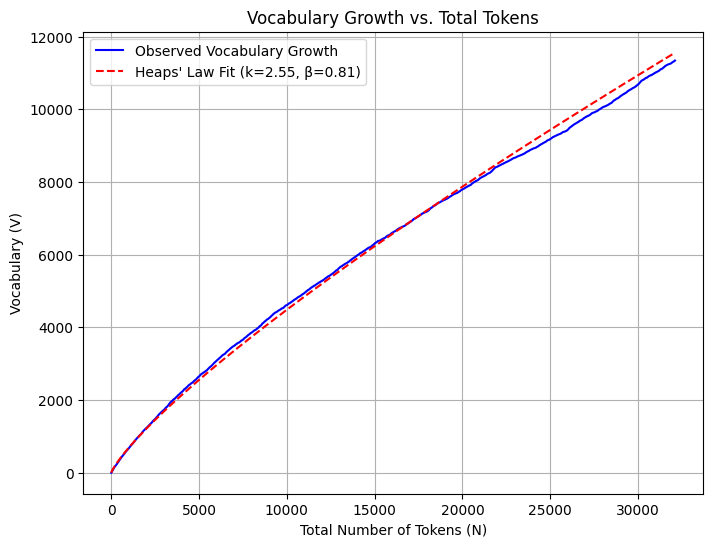

In [6]:
import matplotlib.pyplot as plt

# Observed values
plt.figure(figsize=(8,6))
plt.plot(N, V, label="Observed Vocabulary Growth", color="blue")

# Predicted values using Heaps' law
V_pred = [k * (n ** beta) for n in N]
plt.plot(N, V_pred, label=f"Heaps' Law Fit (k={k:.2f}, β={beta:.2f})", color="red", linestyle="--")

# Labels and legend
plt.xlabel("Total Number of Tokens (N)")
plt.ylabel("Vocabulary (V)")
plt.title("Vocabulary Growth vs. Total Tokens")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
corpus = [list(token) for token in df['tokens']]

In [8]:
def sentence_segmentation(text):
    # split on ., !, ? only when followed by space or end of string
    sentence_endings = re.compile(
        r'([.!?])([\'")\]]*)(?=\s|$)'  # punctuation + optional quotes/brackets, followed by space or end
    )
    # Delimiter for splitting
    segmented = sentence_endings.sub(r'\1\2</s>', text)
    sentences = [s.strip() for s in segmented.split('</s>') if s.strip()]
    return sentences


# BPE Algorithm

In [9]:
def learn_bpe(corpus, num_merges):
    merges = []
    merge_freqs = []   # store (pair, frequency) at each step
    for _ in range(num_merges):
        # Count pairs fresh each iteration
        vocab = {}
        for word in corpus:
            for i in range(len(word)-1):
                pair = (word[i], word[i+1])
                vocab[pair] = vocab.get(pair, 0) + 1
        
        if not vocab:
            break
        
        # Most frequent pair
        most_frequent = max(vocab, key=vocab.get)
        merges.append(most_frequent)
        merge_freqs.append((most_frequent, vocab[most_frequent]))
        
        # Merge in corpus
        new_symbol = ''.join(most_frequent)
        new_corpus = []
        for word in corpus:
            i = 0
            new_word = []
            while i < len(word):
                if i < len(word)-1 and (word[i], word[i+1]) == most_frequent:
                    new_word.append(new_symbol)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_corpus.append(new_word)
        corpus = new_corpus
    
    return merges, corpus, merge_freqs


# Run BPE
merges, updated_corpus, merge_freqs = learn_bpe(corpus, num_merges=1000)

all_tokens = [tok for word in updated_corpus for tok in word]

longest_token = max(all_tokens, key=len)

print("Longest token:", longest_token, "with length:", len(longest_token))

Longest token: tərcüməsi with length: 9


Top 15 frequent BPE pairs:
('ə', 'r'): 3743
('i', '-'): 3573
('ə', 'n'): 3265
('a', 'n'): 2817
('i', 'n'): 2448
('i', 'm'): 2131
('e', 'y'): 1987
('ə', 'm'): 1939
('i', 'r'): 1828
('a', 'r'): 1813
('m', 'ə'): 1539
('i', 'l'): 1426
('o', 'l'): 1360
('a', 'l'): 1229
('ə', 't'): 1086


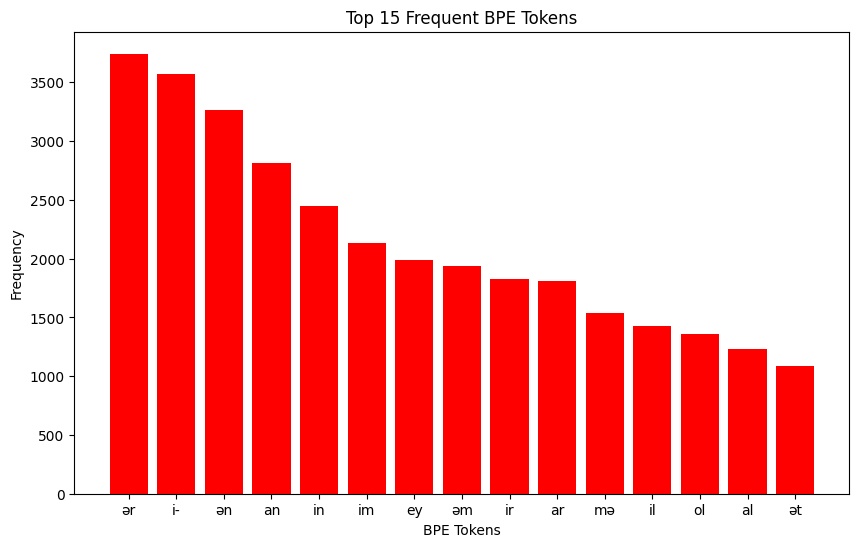

In [10]:
# Take top 15 by frequency
top15 = sorted(merge_freqs, key=lambda x: x[1], reverse=True)[:15]

# Print results
print("Top 15 frequent BPE pairs:")
for pair, freq in top15:
    print(f"{pair}: {freq}")

# Plot histogram
labels = [f"{a}{b}" for (a,b), _ in top15]
counts = [freq for _, freq in top15]

plt.figure(figsize=(10,6))
plt.bar(labels, counts, color="red")
plt.xlabel("BPE Tokens")
plt.ylabel("Frequency")
plt.title("Top 15 Frequent BPE Tokens")
plt.show()


# Processing Text With BPE Tokenizer

In [11]:
def apply_bpe(text, merges):
    text = text.lower()
    # Represent word as characters + end-of-word marker
    chars = list(text) + ["</w>"]
    
    # Apply merges in the order they were learned
    for merge in merges:
        merged = ''.join(merge)
        new_chars = []
        i = 0
        while i < len(chars):
            if i < len(chars)-1 and (chars[i], chars[i+1]) == merge:
                new_chars.append(merged)
                i += 2
            else:
                new_chars.append(chars[i])
                i += 1
        chars = new_chars
    
    return ' '.join(chars)

In [12]:
sample_text = "Bakıdan əlimə çatan qadın jurnallarının birində Kələkoş sözü diqqətimi cəlb etdi. " \
"Bu, elə reseptini axtardığım Kələkoş idi! Amma bu dəfı adın yanında resept də var idi! " \
"Beləliklə sirr dolu Kələkoşu bişirmək fürsətini əldə etmiş oldum. Çox ləzzətli şorbadır! " \
"Tez-tez menyumuza qolaq olur. Buyurun, siz de dadına baxın."

# Sample text - Sentence Segmentation + BPE tokenization

In [13]:
def count_tokens(bpe_text):
    return len(bpe_text.split())


def sentence_tokenizer(sample_text):
    segmented_sentences = sentence_segmentation(sample_text)

    total_tokens = 0
    i = 0

    for sentence in segmented_sentences:
        i+=1
        res = apply_bpe(sentence, merges)
        token_count = count_tokens(res)
        total_tokens += token_count
        print(f"{i})", res, f"{token_count} tokens", "\n")
    print("Total number of tokens:", total_tokens)

sentence_tokenizer(sample_text)

1) ba k ı dan   əl imə   ç at an   q ad ın   j ur nal ların ın   bir ində   k əl ək o ş   söz ü   di q qət imi   c əl b   etdi . </w> 36 tokens 

2) bu ,   e lə   r e s e p t ini   ax tar dı ğ ım   k əl ək o ş   idi ! </w> 24 tokens 

3) am ma   bu   dəf ı   ad ın   yan ında   r e s e p t   də   var   idi ! </w> 20 tokens 

4) b el əl ik lə   sir r   d ol u   k əl ək o şu   b iş ir mək   f ür s ət ini   əl də   etmiş   oldu m . </w> 31 tokens 

5) çox   lə z z ət li   ş or ba dır ! </w> 12 tokens 

6) t e z - t e z   me n yu mu z a   q ola q   olur . </w> 19 tokens 

7) bu y ur un ,   siz   de   da dın a   bax ın . </w> 14 tokens 

Total number of tokens: 156


# Input Sentence Segmentation + BPE Tokenization

In [14]:
while True:
    sample_text = input("Enter a sentence (or press Enter to quit): ")
    if not sample_text.strip():
        break
    sentence_tokenizer(sample_text)

# Levenstein Distance & BK-tree

In [15]:
import numpy as np
from collections import deque

class Node:
    def __init__(self, label):
        self.label = label
        self.children = {}
    
    def __str__(self):
        return self.label
    
class BKtree:
    def __init__(self, labels = None):
        self.root = None
        if labels:
            for i in labels:
                self.add(i)

    def add(self, label):
        if self.root is None:
            self.root = Node(label)
        else:
            node = Node(label)
            current = self.root
            distance = Levenstein(label, current.label)

            while distance in current.children.keys():
                current = current.children.get(distance)
                distance = Levenstein(label, current.label)
            current.children[distance] = node
    
    def search(self, label, max_dist):
        candidates = deque([self.root])
        found = []

        while len(candidates) > 0:
            node = candidates.popleft()
            distance = Levenstein(label, node.label)

            if(distance <= max_dist):
                found.append(node)

            candidates.extend(child_node for child_dist, child_node in node.children.items()
                              if distance - max_dist <= child_dist <= distance + max_dist)
        
        return found


def Levenstein(a, b):
    n = len(a)
    m = len(b)

    lev = np.zeros((n+1, m+1))

    for i in range (0, n+1):
        lev[i, 0] = i

    for i in range (0, m+1):
        lev[0, i] = i

    for i in range (1, n+1):
        for j in range (1, m+1):
            insertion = lev[i - 1, j] + 1
            deletion = lev[i, j - 1] + 1
            substitution = lev[i-1, j-1] + (1 if (a[i-1] != b[j-1])  else 0)
            lev[i, j] = min(insertion, deletion, substitution)
    
    return lev[n, m]


# Keyboard layout based Confusion Matrix

In [16]:
import math

keyboard_az = {
  
    'q': (0, 0), 'ü': (1, 0), 'e': (2, 0), 'r': (3, 0),
    't': (4, 0), 'y': (5, 0), 'u': (6, 0), 'i': (7, 0),
    'o': (8, 0), 'p': (9, 0), 'ö': (10, 0), 'ğ': (11, 0),
    '-': (12, 0),

    
    'a': (0.5, 1), 's': (1.5, 1), 'd': (2.5, 1), 'f': (3.5, 1),
    'g': (4.5, 1), 'h': (5.5, 1), 'j': (6.5, 1), 'k': (7.5, 1),
    'l': (8.5, 1), 'ı': (9.5, 1), 'ə': (10.5, 1),
    "'": (11.5, 1),
      

    
    'z': (1, 2), 'x': (2, 2), 'c': (3, 2), 'v': (4, 2),
    'b': (5, 2), 'n': (6, 2), 'm': (7, 2), 'ç': (8, 2),
    'ş': (9, 2)
}

def distance(c1, c2, layout):
    x_1, y_1 = layout[c1]
    x_2, y_2 = layout[c2]
    return math.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)

matrix_dist = {}

for c in keyboard_az:
    row = {}
    for k in keyboard_az:
        if c == k:
            row[k] = 1.0
        else:
            dist = distance(c, k, keyboard_az)
            row[k] = 1/(dist + 1)
    matrix_dist[c] = row

matrix_prob = {}

for c, row in matrix_dist.items():
    total = sum(row.values())
    matrix_prob[c] = {k: v/total for k, v in row.items()}

matrix_prob['i']['ı'] = max(matrix_prob['i']['ı'],0.7)
matrix_prob['ı']['i'] = max(matrix_prob['ı']['i'],0.8)
matrix_prob['ü']['u'] = max(matrix_prob['ü']['u'],0.8)
matrix_prob['u']['ü'] = max(matrix_prob['u']['ü'],0.7)
matrix_prob['ö']['o'] = max(matrix_prob['ö']['o'],0.8)
matrix_prob['o']['ö'] = max(matrix_prob['o']['ö'],0.7)
matrix_prob['ğ']['g'] = max(matrix_prob['ğ']['g'],0.8)
matrix_prob['g']['ğ'] = max(matrix_prob['g']['ğ'],0.9)
matrix_prob['e']['ə'] = max(matrix_prob['e']['ə'],0.7)
matrix_prob['ə']['e'] = max(matrix_prob['ə']['e'],0.8)
matrix_prob['ç']['c'] = max(matrix_prob['ç']['c'],0.8)
matrix_prob['c']['ç'] = max(matrix_prob['c']['ç'],0.8)
matrix_prob['ş']['s'] = max(matrix_prob['ş']['s'],0.8)
matrix_prob['s']['ş'] = max(matrix_prob['s']['ş'],0.9)


for c, row in matrix_prob.items():
    total = sum(row.values())
    for k in row:
        row[k] = row[k] / total

matrix_cost = {}

for c, row in matrix_prob.items():
    matrix_cost[c] = {k: -math.log(v) for k, v in row.items()}




# Weighted Edit Distance & BK-tree

In [17]:
import KeyboardConfusionMatrix
import numpy as np
from collections import deque

class Node:
    def __init__(self, label):
        self.label = label
        self.children = {}
    
    def __str__(self):
        return self.label
    
class WBKtree:
    def __init__(self, labels = None):
        self.root = None
        if labels:
            for i in labels:
                self.add(i)

    def add(self, label):
        if self.root is None:
            self.root = Node(label)
        else:
            node = Node(label)
            current = self.root
            distance = WeightedLevenstein(label, current.label)

            while distance in current.children.keys():
                current = current.children.get(distance)
                distance = WeightedLevenstein(label, current.label)
            current.children[distance] = node
    
    def search(self, label, max_dist):
        candidates = deque([self.root])
        found = []

        while len(candidates) > 0:
            node = candidates.popleft()
            distance = WeightedLevenstein(label, node.label)

            if(distance <= max_dist):
                found.append(node)

            candidates.extend(child_node for child_dist, child_node in node.children.items()
                              if distance - max_dist <= child_dist <= distance + max_dist)
        
        return found


def WeightedLevenstein(a, b):
    n, m = len(a), len(b)
    lev = np.zeros((n+1, m+1))
    vowels = "üöıəeuoa"

    for i in range(1, n+1):
        lev[i, 0] = lev[i-1, 0] + (1 if a[i-1] in vowels else 0.5)

    for j in range(1, m+1):
        lev[0, j] = lev[0, j-1] + (1 if b[j-1] in vowels else 0.5)

    for i in range(1, n+1):
        for j in range(1, m+1):
            ins = lev[i-1, j] + (1 if a[i-1] in vowels else 0.5)
            dele = lev[i, j-1] + (1 if b[j-1] in vowels else 0.5)

            if a[i-1] == b[j-1]:
                sub_cost = 0
            elif (a[i-1] in KeyboardConfusionMatrix.matrix_cost and
                  b[j-1] in KeyboardConfusionMatrix.matrix_cost[a[i-1]]):
                sub_cost = KeyboardConfusionMatrix.matrix_cost[a[i-1]][b[j-1]]
            else:
                sub_cost = 1.0

            sub = lev[i-1, j-1] + sub_cost
            lev[i, j] = min(ins, dele, sub)

    return lev[n, m]


# Spelling Checker

In [18]:
import regex as re

tokens = re.findall(r"\p{L}+(?:[’']\p{L}+)*(?:-\p{L}+)*", input_text)
tokens = [t.replace("’", "'") for t in tokens]
tokens = [t.lower() for t in tokens]
vocabulary = set()

for t in tokens:
    vocabulary.add(t)

max_threshold = 0
mode = ""
search_word = ""

while(mode not in ("l", "w")):
    mode = input("Choose edit distance (l - Levenstein edit distance, w - weighted edit distance):")

search_word = input("Provide search word: ")

while True:
    max_threshold = input("Provide maximum threshold: ")

    try:
        max_threshold = int(max_threshold)
        if max_threshold > 0:
            break
        else:
            print("Threshold must be a positive integer.")
    except ValueError:
        print("Please enter a valid integer.")

    
max_threshold = int(max_threshold)  

if(mode == 'w'):
    tt = WBKtree(vocabulary)
    res = tt.search(search_word, 2)
    sorted_res = sorted(res, key = lambda w:( WeightedLevenstein(w.label, search_word)))
else:
    tt = BKtree(vocabulary)
    res = tt.search(search_word, 2)
    sorted_res = sorted(res, key = lambda w:( Levenstein(w.label, search_word)))


if not sorted_res: print("No words found")
else:
    for i in sorted_res:
        print(i)


evim
sim
kim
edim
əşkim
eşqim
eyşim
həkim
gem
im
verim
menim
hek
etdim
yerim
ki
yetim
meyim
dedim
eyi
qem
etsin
kimi
elm
e
deyim
peyki
evi
